Print information of MNIST dataset

Training data shape: (60000, 28, 28)
Testing data shape: (10000, 28, 28)
Label of the first image: 5


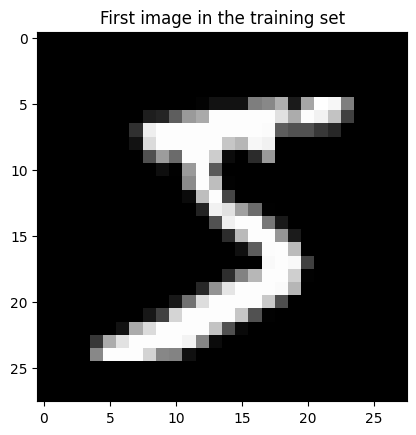

In [8]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Print the shape of the data (this will give you the dimensions)
print("Training data shape:", x_train.shape) # Example output: (60000, 28, 28)
print("Testing data shape:", x_test.shape)   # Example output: (10000, 28, 28)

# Print the label of the first image in the training set
print("Label of the first image:", y_train[0])

# Display the first image from the training set
plt.imshow(x_train[0], cmap='gray')
plt.title('First image in the training set')
plt.show()

Print information after preprocessing of MNIST

[INFO] Dataset loaded!
Training Data:
X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)

Test Data:
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


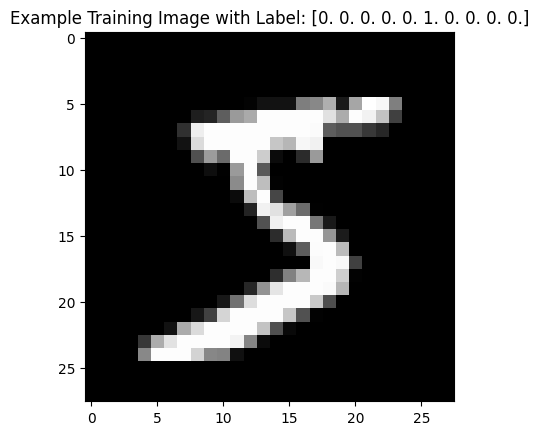

TF Train Data: <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)), (TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)))>
TF Test Data: <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)), (TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)))>


In [26]:
from EfficientCapsNet.utils import Dataset

# Create a Dataset object for MNIST
dataset_mnist = Dataset(model_name='MNIST', config_path='EfficientCapsNet/config.json')

# Print dimensions and relevant information for training and test sets
print("Training Data:")
print("X_train shape:", dataset_mnist.X_train.shape)
print("y_train shape:", dataset_mnist.y_train.shape)

print("\nTest Data:")
print("X_test shape:", dataset_mnist.X_test.shape)
print("y_test shape:", dataset_mnist.y_test.shape)

# You can also inspect specific examples to understand what the data looks like
import matplotlib.pyplot as plt

plt.imshow(dataset_mnist.X_train[0, :, :, 0], cmap='gray')
plt.title("Example Training Image with Label: " + str(dataset_mnist.y_train[0]))
plt.show()

# If you also want to get the tf.data objects, you can call the get_tf_data method
train_data, test_data = dataset_mnist.get_tf_data()
print("TF Train Data:", train_data)
print("TF Test Data:", test_data)

Print image dimension of own dataset

In [28]:
import cv2
import glob

# Get a sorted list of PNG files in the "Datasets" directory
files = sorted(glob.glob("Dataset/*.png"))

# Check if there are any files in the directory
if files:
    # Load the first image
    image_path = files[0]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Print the dimensions
    if image is not None:
        print("Dimensions of the image:", image.shape)
    else:
        print("Failed to read the image.")
else:
    print("No PNG files found in the 'Datasets' directory.")

Dimensions of the image: (2732, 2048)


Process own dataset into MNIST format and print information

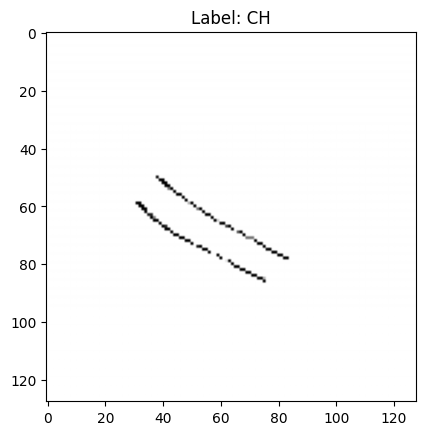

X shape: (363, 128, 128, 1)
y shape: (363, 11)


In [32]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 128 # Change this to your desired image size
NUM_CLASSES = 11 # Change this to the number of classes you have

# Load images and labels
images = []
labels = []
files = sorted(glob.glob("Dataset/*.png"))
for file in files:
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    images.append(image[..., None])
    label = file.split('_')[-1][:-4] # Assuming label is 'CH' part of the filename
    labels.append(label)

# Convert to numpy arrays
X = np.array(images, dtype=np.float32) / 256
y_labels = np.array(labels)
unique_labels = np.unique(y_labels)

# Plot the first image
image = X[0].squeeze() # Remove any singleton dimensions if necessary
plt.imshow(image, cmap='gray')
plt.title(f'Label: {labels[0]}')
plt.show()

# Map the labels to integers
label_mapping = {label: idx for idx, label in enumerate(set(y_labels))}
y = [label_mapping[label] for label in y_labels]

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=NUM_CLASSES)

# Print shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

## Create new dataset by:
1. Resize and grayscale existing images
2. Offset each black pixel vertically and horizantally to generate a larger number of samples 

In [33]:
# 1. Resize, grayscale, and altered images in new directory

import cv2
import os
import glob

# Make sure the directory exists
if not os.path.exists('Dataset_formatted'):
    os.makedirs('Dataset_formatted')

# Get all the .png files in the "Dataset" directory
files = glob.glob("Dataset/*.png")

for file in files:
    # Read the image and grayscale it
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    # Resize the image to 128x128
    image_resized = cv2.resize(image, (128, 128))

    # Create a new filename for the formatted image
    filename = os.path.join('Dataset_formatted', os.path.basename(file))

    # Save the formatted image
    cv2.imwrite(filename, image_resized)

print(f"Formatted {len(files)} images and saved to 'Dataset_formatted'")

Formatted 363 images and saved to 'Dataset_formatted'


Processing file: 0054_RR.png


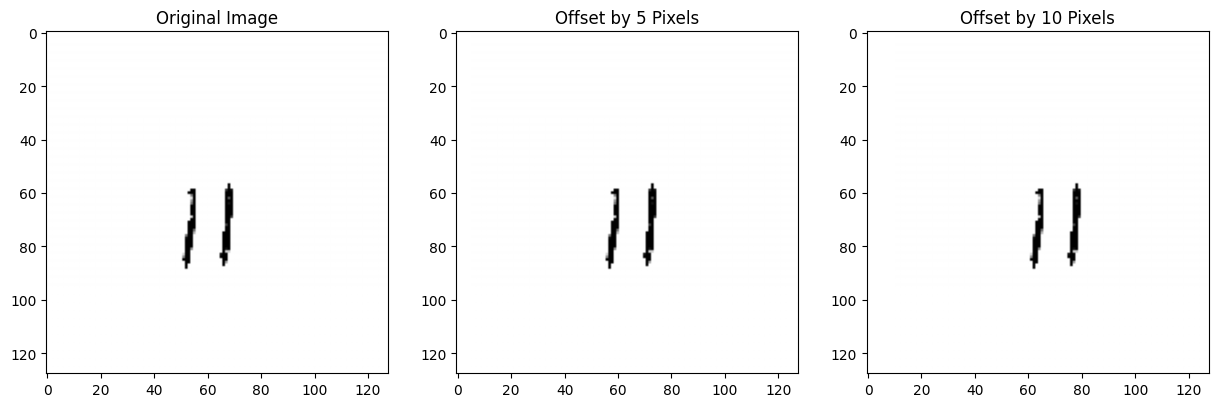

In [43]:
# 2. Assess by how many pixels each image should be offsetted

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

# Get the first image in the "Dataset_formatted" directory
file = glob.glob("Dataset_formatted/*.png")[0]
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

filename = os.path.basename(file)
print("Processing file:", filename)


def offset_black_pixels(image, offset):
    offset_image = np.full_like(image, 255) # Creating a new white image of the same shape
    for i in range(image.shape[0]):
        # offset is deducted to avoid an index out of bound error
        for j in range(image.shape[1] - offset):
            offset_image[i, j + offset] = image[i, j]
    return offset_image


# Create images with black pixels offset by 5 and 10 pixels
image_offset_5 = offset_black_pixels(image, 5)
image_offset_10 = offset_black_pixels(image, 10)

# Plot all three images
plt.figure(figsize=[15,5])

plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(image_offset_5, cmap='gray')
plt.title('Offset by 5 Pixels')

plt.subplot(1,3,3)
plt.imshow(image_offset_10, cmap='gray')
plt.title('Offset by 10 Pixels')

plt.show()


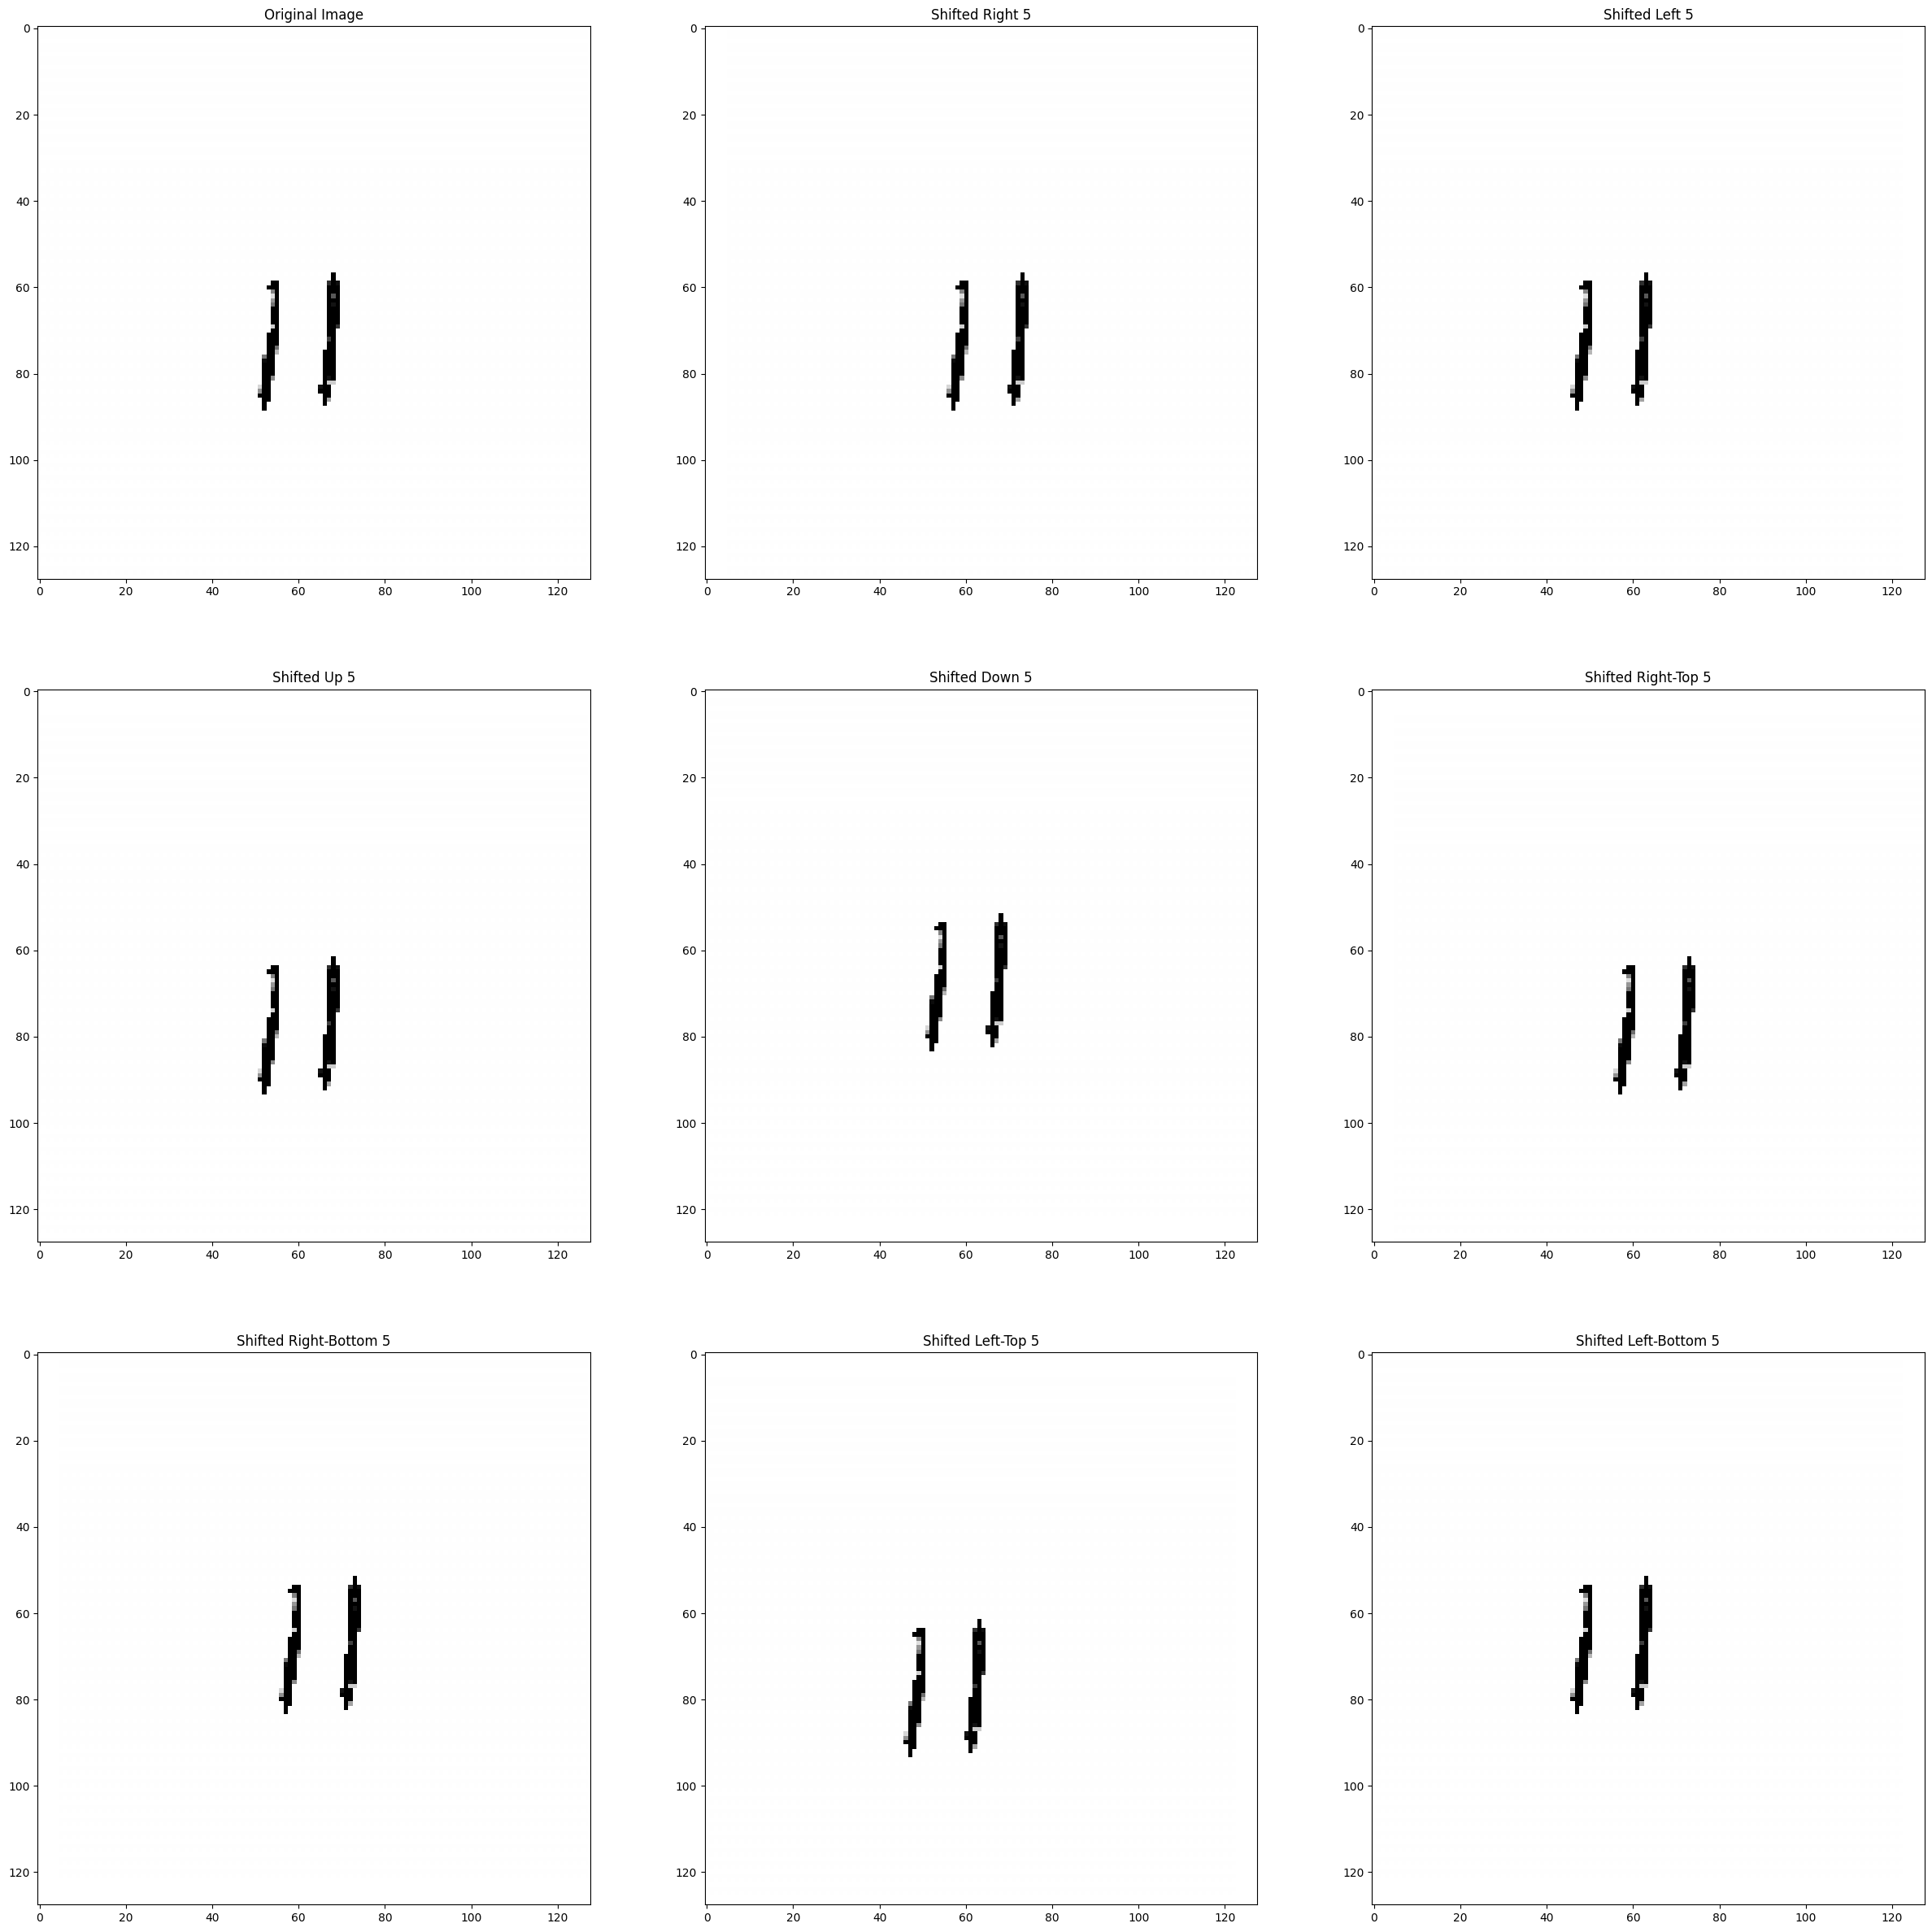

In [49]:
# 2. Create extended dataset

# Test on one image

import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

def shift_pixels(image, offset_x, offset_y):
    shifted_image = np.full_like(image, 255) # Create a white canvas with the same shape as the input image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Calculate the shifted coordinates
            i_shifted = i - offset_y
            j_shifted = j - offset_x

            # Check if the shifted coordinates are within the bounds of the image
            if 0 <= i_shifted < image.shape[0] and 0 <= j_shifted < image.shape[1]:
                shifted_image[i, j] = image[i_shifted, j_shifted]

    return shifted_image


# Path to the "Dataset_formatted" directory
dataset_path = "Dataset_formatted"

# Get the filenames from the directory
filenames = os.listdir(dataset_path)

# Read the first image (you can choose any)
image_path = os.path.join(dataset_path, filenames[0])
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define the shifts in the 8 directions
shifts = [(5, 0), (-5, 0), (0, 5), (0, -5), (5, 5), (5, -5), (-5, 5), (-5, -5)]
labels = ["Right 5", "Left 5", "Up 5", "Down 5", "Right-Top 5", "Right-Bottom 5", "Left-Top 5", "Left-Bottom 5"]

# Plot the original image
plt.figure(figsize=(30, 30))
plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

# Plot the shifted images
for i, (offset_x, offset_y) in enumerate(shifts):
    shifted_image = shift_pixels(image, offset_x, offset_y)
    plt.subplot(3, 3, i + 2)
    plt.imshow(shifted_image, cmap='gray')
    plt.title(f"Shifted {labels[i]}")

plt.show()


In [ ]:
# 2 Apply on whole dataset

files = sorted(glob.glob("Dataset_formatted/*.png"))

counter = len(files) + 1

for file in files:
    # Read the image
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    # Extract the filename
    filename = os.path.basename(file)
    base_name, label = filename.split("_")

    # Offsets for shifting
    offsets = [(5, 0), (-5, 0), (0, 5), (0, -5), (5, 5), (5, -5), (-5, 5), (-5, -5)]

    for offset_x, offset_y in offsets:
        offset_image = shift_pixels(image, offset_x, offset_y)
        counter += 1
        new_filename = "{:04d}_{}".format(counter, label)
        cv2.imwrite(os.path.join("Dataset_formatted", new_filename), offset_image)

    print(f"Processed file: {filename}")

print("All images processed.")